In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt

# import lightgbm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

## **DRIVE LOAD**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_parquet("/content/drive/MyDrive/ParquetFile/model_data.parquet")

## **Split Data**

In [5]:
train = data[data['date_id'] < '2016-04-01']
test  = data[data['date_id'] >= '2016-04-01']

y_train = train['units_sold']
y_test = test['units_sold']

In [6]:
base_features = [
    'price', 'day_of_week', 'day_of_year', 'month', 'year',
    'store_id', 'item_id', 'dept_id', 'cat_id',
    'weekday', 'event_name', 'event_type'
]

lag_features = [f'lag_{lag}' for lag in [1, 7, 28]]
rolling_features = ['rolling_7', 'rolling_28', 'rolling_std_7']
price_features = ['price_change_1', 'price_change_7']
event_features = ['event_window_7']

features = (
    base_features
    + lag_features
    + rolling_features
    + price_features
    + event_features
)

In [7]:
cat_cols = ['store_id', 'item_id', 'dept_id', 'cat_id', 'weekday',
            'event_name', 'event_type']

encoder = ce.TargetEncoder(cols=cat_cols)

X_train = encoder.fit_transform(train[features], y_train)
X_test = encoder.transform(test[features])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5591351 entries, 0 to 5663384
Data columns (total 21 columns):
 #   Column          Dtype  
---  ------          -----  
 0   price           float64
 1   day_of_week     int32  
 2   day_of_year     int32  
 3   month           int64  
 4   year            int64  
 5   store_id        float64
 6   item_id         float64
 7   dept_id         float64
 8   cat_id          float64
 9   weekday         float64
 10  event_name      float64
 11  event_type      float64
 12  lag_1           float64
 13  lag_7           float64
 14  lag_28          float64
 15  rolling_7       float64
 16  rolling_28      float64
 17  rolling_std_7   float64
 18  price_change_1  float64
 19  price_change_7  float64
 20  event_window_7  float64
dtypes: float64(17), int32(2), int64(2)
memory usage: 895.8 MB


In [8]:
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

Training set size: 5591351 rows
Testing set size: 72058 rows


## Train XGBoost

In [15]:
from sklearn.metrics.pairwise import device

xgb_model = xgb.XGBRegressor(

    objective='reg:tweedie',
    eval_metric='mae',

    # GPU
    tree_method = 'hist',
    device = "cuda",

    # Tham số
    n_estimators=10000,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=20,
    subsample=0.7,
    colsample_bytree=0.8,
    tweedie_variance_power = 1.5,

    reg_alpha=0.1,
    random_state=42,
    n_jobs=-1,
)
xgb_model.fit(X_train, y_train)

print("XGBoost model trained successfully with default parameters.")

XGBoost model trained successfully with default parameters.


## Metrix

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Ensure y_test and y_pred are numpy arrays for consistent operations
y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_np = y_pred

# Calculate standard regression metrics
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

# Custom function for Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    # Avoid division by zero by replacing 0s with a small epsilon
    y_true_safe = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

# Custom function for Weighted Mean Absolute Percentage Error (WMAPE)
def calculate_wmape(y_true, y_pred):
    # Avoid division by zero for the sum of y_true
    sum_y_true = np.sum(y_true)
    if sum_y_true == 0:
        return np.inf  # or 0, depending on desired behavior for all zeros
    return np.sum(np.abs(y_true - y_pred)) / sum_y_true * 100

# Custom function for Root Mean Squared Scaled Error (RMSSE)
def calculate_rmsse(y_train_true, y_test_true, y_test_pred):
    # Calculate the naive forecast denominator using the training data
    # RMSSE = sqrt(MSE_test / (1/(N-1) * sum((y_train[i] - y_train[i-1])^2)))
    n_train = len(y_train_true)
    if n_train <= 1:
        return np.inf

    # Calculate squared differences for naive forecast on training data
    squared_diff_train = (y_train_true.diff().dropna())**2
    denominator = np.sqrt(np.sum(squared_diff_train) / (n_train - 1))

    if denominator == 0:
        return np.inf

    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    return rmse_test / denominator

# Calculate custom metrics
mape = calculate_mape(y_test_np, y_pred_np)
wmape = calculate_wmape(y_test_np, y_pred_np)
rmsse = calculate_rmsse(y_train, y_test_np, y_pred_np)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Weighted Mean Absolute Percentage Error (WMAPE): {wmape:.4f}%")
print(f"Root Mean Squared Scaled Error (RMSSE): {rmsse:.4f}")


Mean Squared Error (MSE): 4.3453
Root Mean Squared Error (RMSE): 2.0845
Mean Absolute Error (MAE): 1.0982
R2 Score: 0.6533
Weighted Mean Absolute Percentage Error (WMAPE): 71.2239%
Root Mean Squared Scaled Error (RMSSE): 0.7214


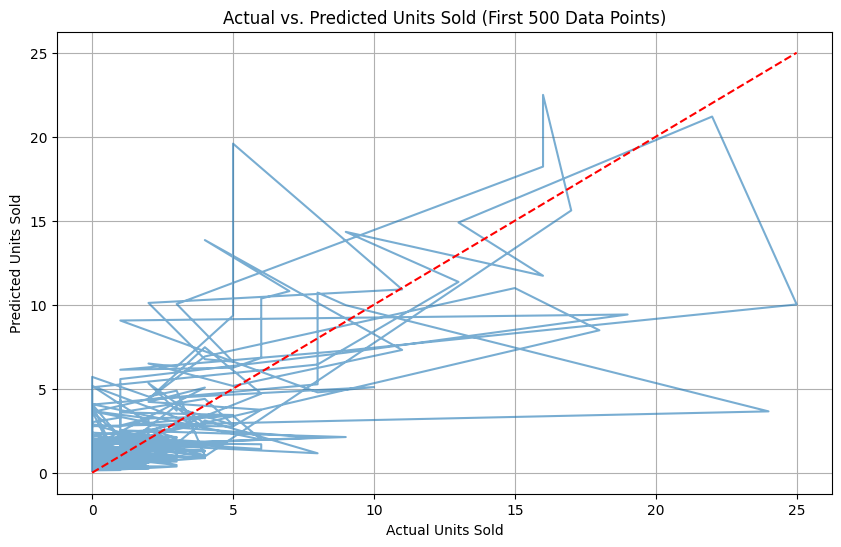

In [18]:
import matplotlib.pyplot as plt

# Lấy 500 điểm dữ liệu đầu tiên từ y_test_np và y_pred_np
num_points = 500
y_test_subset = y_test_np[:num_points]
y_pred_subset = y_pred_np[:num_points]

# Tạo biểu đồ scatter plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_subset, y_pred_subset, alpha=0.6)
plt.plot([min(y_test_subset), max(y_test_subset)], [min(y_test_subset), max(y_test_subset)], 'r--') # Đường tham chiếu y=x
plt.title('Actual vs. Predicted Units Sold (First 500 Data Points)')
plt.xlabel('Actual Units Sold')
plt.ylabel('Predicted Units Sold')
plt.grid(True)
plt.show()

In [19]:
import joblib
import os

# Define the path to save the model in Google Drive
model_filename = 'xgboost_model.joblib'
model_path = os.path.join('/content/drive/MyDrive/XGBoost_Models', model_filename)

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the XGBoost model
joblib.dump(xgb_model, model_path)

print(f"XGBoost model saved successfully to: {model_path}")

XGBoost model saved successfully to: /content/drive/MyDrive/XGBoost_Models/xgboost_model.joblib


## Outlier/Noise

In [11]:
def analyze_large_ts_metrics(df, window_size=50, z_threshold=3, calc_iqr=True):
    """
    Phân tích chỉ số thống kê, nhiễu và outlier cho tập dữ liệu lớn.
    Trả về bảng báo cáo dạng DataFrame thay vì biểu đồ.

    Parameters:
    - df: DataFrame chứa dữ liệu (5 triệu dòng).
    - window_size: Kích thước cửa sổ trượt (lưu ý: với 5M dòng, window nên đủ lớn).
    - z_threshold: Ngưỡng Z-score (thường là 3).
    - calc_iqr: (Bool) Có tính Rolling IQR không? (Lưu ý: Rolling Quantile chạy khá chậm trên dữ liệu lớn, set False nếu muốn tốc độ cực nhanh).

    Returns:
    - summary_df: Bảng tổng hợp các chỉ số của từng cột.
    """

    # Chỉ lấy các cột dữ liệu số (loại bỏ cột ngày tháng hoặc string)
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    results = []
    print(f"Đang xử lý {len(numeric_cols)} cột dữ liệu với {len(df)} dòng/cột...")

    for col_name in numeric_cols:
        # Lấy series dữ liệu (dùng copy để không ảnh hưởng data gốc)
        series = df[col_name]

        # Bỏ qua nếu cột toàn NaN
        if series.isnull().all():
            continue

        # 1. Tính toán cơ bản
        # Dùng float32 để tiết kiệm RAM nếu cần, ở đây giữ nguyên để đảm bảo độ chính xác
        rolling_mean = series.rolling(window=window_size, center=True).mean()
        rolling_std = series.rolling(window=window_size, center=True).std()

        # Residual (Nhiễu tách biệt khỏi xu hướng)
        residual = series - rolling_mean
        valid_residual = residual.dropna() # Bỏ NaN để tính stats

        # 2. Đánh giá Outlier theo Z-Score (Nhanh)
        # Cộng 1e-9 để tránh chia cho 0
        z_scores = residual / (rolling_std + 1e-9)
        outlier_z_count = (z_scores.abs() > z_threshold).sum()

        # 3. Đánh giá Outlier theo Rolling IQR (Chậm hơn, tuỳ chọn)
        outlier_iqr_count = 0
        if calc_iqr:
            # Rolling quantile tốn nhiều tài nguyên tính toán
            Q1 = series.rolling(window=window_size, center=True).quantile(0.25)
            Q3 = series.rolling(window=window_size, center=True).quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outlier_iqr_count = ((series < lower) | (series > upper)).sum()

        # 4. Tính các chỉ số độ nhiễu
        noise_std = valid_residual.std()
        signal_mean = abs(series.mean())
        # Signal to Noise Ratio
        snr = signal_mean / noise_std if noise_std != 0 else 0

        # Độ nhọn và độ lệch (Dùng thư viện scipy hoặc pandas)
        # Kurtosis > 3 báo hiệu nhiều outlier đuôi nặng
        kurt_val = valid_residual.kurtosis()
        skew_val = valid_residual.skew()

        # 5. Đóng gói kết quả
        row_result = {
            'Column': col_name,
            'Total_Rows': len(series),
            'Outlier_Z_Count': outlier_z_count,
            'Outlier_Z_Ratio (%)': round((outlier_z_count / len(series)) * 100, 3),
            'Outlier_IQR_Count': outlier_iqr_count if calc_iqr else 'N/A',
            'Outlier_IQR_Ratio (%)': round((outlier_iqr_count / len(series)) * 100, 3) if calc_iqr else 'N/A',
            'Noise_Std (Stability)': round(noise_std, 4),
            'SNR (Quality)': round(snr, 2),
            'Kurtosis': round(kurt_val, 2),
            'Skewness': round(skew_val, 2)
        }
        results.append(row_result)

    # Tạo DataFrame báo cáo
    summary_df = pd.DataFrame(results)

    # Sắp xếp theo mức độ nhiễu (Noise Std) giảm dần để dễ nhìn cột nào xấu nhất
    if not summary_df.empty:
        summary_df = summary_df.sort_values(by='Noise_Std (Stability)', ascending=False).reset_index(drop=True)

    return summary_df

In [12]:
print("Đang phân tích biến data...")
bao_cao, data_chi_tiet = evaluate_ts_health(
    data=data,
    window_size=20,
    time_col = 'date_id',
    value_col = 'units_sold'
)
print(bao_cao)
print(data_chi_tiet)

Đang phân tích biến data...


NameError: name 'evaluate_ts_health' is not defined